In [1]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\tulsi\Desktop\temp\data.csv",
    encoding="ISO-8859-1",
    engine="python"
)

df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
df.shape
df.columns



Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
df['InvoiceNo'].astype(str).str.startswith('C').value_counts()   


InvoiceNo
False    397924
True       8905
Name: count, dtype: int64

In [7]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [8]:
(df['Quantity'] <= 0).sum()
(df['UnitPrice'] <= 0).sum()


40

In [9]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [10]:
df.describe()


,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [11]:
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)


In [12]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()


(Timestamp('2010-01-12 08:26:00'), Timestamp('2011-12-10 17:19:00'))

In [13]:
df.duplicated().sum()


5192

In [14]:
dup_rows = df[df.duplicated(keep=False)]
dup_rows.shape


(10001, 8)

In [15]:
dup_counts = (
    df
    .groupby(df.columns.tolist())
    .size()
    .reset_index(name="count")
    .query("count > 1")
    .sort_values("count", ascending=False)
)

dup_counts.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,count
146367,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-05-06 11:37:00,2.95,16923.0,United Kingdom,20
146366,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,2011-05-06 11:37:00,2.95,16923.0,United Kingdom,12
303102,572861,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-10-26 12:46:00,1.25,14102.0,United Kingdom,8
35468,541266,21755,LOVE BUILDING BLOCK WORD,1,2011-01-16 16:25:00,5.95,15673.0,United Kingdom,6
16698,538514,21756,BATH BUILDING BLOCK WORD,1,2010-12-12 14:27:00,5.95,15044.0,United Kingdom,6


In [16]:
dup_invoice_counts = (
    dup_counts
    .groupby("InvoiceNo")["count"]
    .sum()
    .sort_values(ascending=False)
)

dup_invoice_counts.head()


InvoiceNo
547651    57
579458    53
577482    52
572103    50
574481    49
Name: count, dtype: int64

In [17]:
dup_counts.iloc[0]


InvoiceNo                              555524
StockCode                               22698
Description    PINK REGENCY TEACUP AND SAUCER
Quantity                                    1
InvoiceDate               2011-05-06 11:37:00
UnitPrice                                2.95
CustomerID                            16923.0
Country                        United Kingdom
count                                      20
Name: 146367, dtype: object

In [20]:
df = df.drop_duplicates()


## Customer Retention Cohort Analysis

### Goal
Group customers by their **first purchase month** and track how many customers return in subsequent months.

### What This Shows
- Each row represents a cohort of customers acquired in the same month  
- Each column shows the percentage of customers who returned after *n* months  
- Darker cells indicate higher retention

### Why It Matters
This analysis helps identify early churn, long-term customer loyalty, and differences in retention behavior across acquisition periods.



In [21]:
# First purchase month for each customer
df['CohortMonth'] = (
    df.groupby('CustomerID')['InvoiceDate']
      .transform('min')
      .dt.to_period('M')
)


In [22]:
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')


In [23]:
df['CohortIndex'] = (
    (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 +
    (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month) + 1
)


In [24]:
cohort_counts = (
    df
    .groupby(['CohortMonth', 'CohortIndex'])['CustomerID']
    .nunique()
    .reset_index()
)


In [25]:
cohort_table = cohort_counts.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)


In [26]:
cohort_sizes = cohort_table.iloc[:, 0]

retention = cohort_table.divide(cohort_sizes, axis=0)


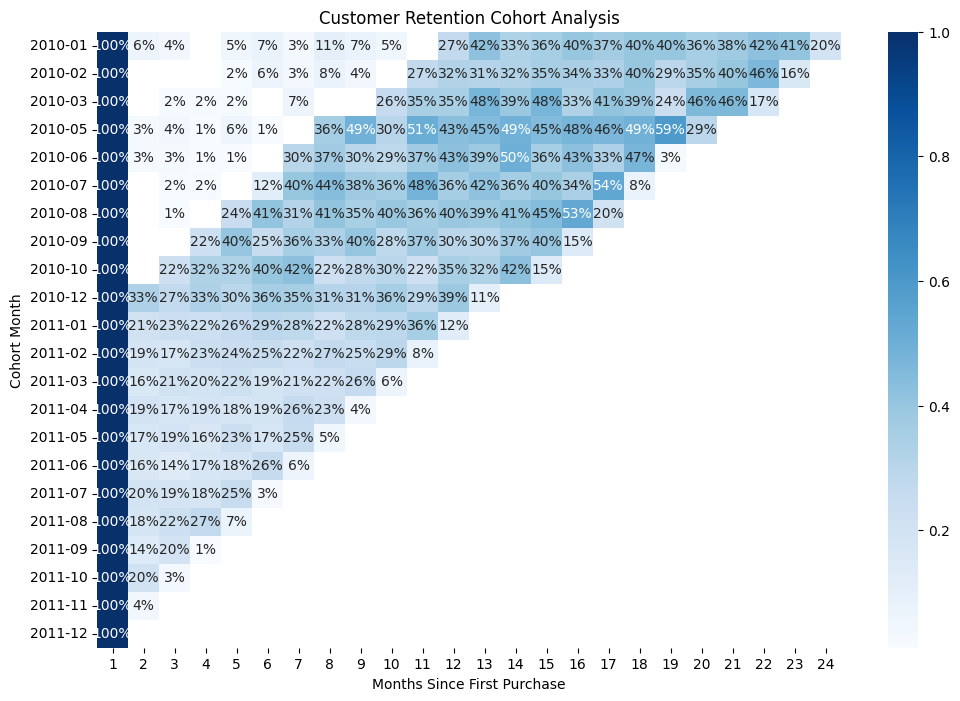

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(
    retention,
    annot=True,
    fmt=".0%",
    cmap="Blues"
)

plt.title("Customer Retention Cohort Analysis")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()


## Key Insights

- Customer retention drops sharply after the first month across most cohorts, indicating early churn.
- Cohorts acquired in mid-2010 show stronger long-term retention compared to later cohorts.
- Customers who return after 3–4 months tend to remain active for longer periods.


## Business Recommendations

- Introduce onboarding or follow-up campaigns within the first 30 days to reduce early churn.
- Target high-retention cohorts with loyalty or bulk purchase incentives.
- Segment wholesale customers for tailored retention strategies.


In [31]:
# Customers who returned after first month
returning_customers = df[df['CohortIndex'] > 1]['CustomerID'].unique()


In [32]:
all_customers = df['CustomerID'].unique()



In [33]:
churned_customers = set(all_customers) - set(returning_customers)


In [34]:
total_customers = len(all_customers)
churned_count = len(churned_customers)

first_month_churn_rate = churned_count / total_customers

total_customers, churned_count, first_month_churn_rate


(4338, 1624, 0.3743660673121254)

In [35]:
cohort_sizes = (
    df[df['CohortIndex'] == 1]
    .groupby('CohortMonth')['CustomerID']
    .nunique()
)

returning_by_cohort = (
    df[df['CohortIndex'] > 1]
    .groupby('CohortMonth')['CustomerID']
    .nunique()
)

first_month_churn = (
    1 - (returning_by_cohort / cohort_sizes)
).fillna(1)

first_month_churn.head()


CohortMonth
2010-01    0.178947
2010-02    0.182796
2010-03    0.130435
2010-05    0.043478
2010-06    0.071429
Freq: M, Name: CustomerID, dtype: float64

## First-Month Churn Insights

- Overall first-month churn rate is approximately **37%**, which is within the normal range for e-commerce.
- Several cohorts from early 2010 show **significantly lower churn**, with some cohorts retaining over 90% of customers beyond the first month.
- This suggests strong early customer engagement and possibly the presence of high-value or wholesale buyers during these periods.


In [38]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']


In [39]:
df[['Quantity', 'UnitPrice', 'Revenue']].head()


,Quantity,UnitPrice,Revenue
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [41]:
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')

df['CohortMonth'] = (
    df.groupby('CustomerID')['InvoiceDate']
      .transform('min')
      .dt.to_period('M')
)

df['CohortIndex'] = (
    (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 +
    (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month) + 1
)


In [42]:
revenue_cohort.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01,46192.49,4861.22,3795.89,NaN,2668.38,4544.86,2187.38,4410.07,3315.62,3375.16,...,56108.73,53708.75,59809.65,57307.10,81396.14,59154.19,78048.72,63152.26,109397.08,16201.9
2010-02,42336.35,NaN,NaN,NaN,2716.64,3245.93,550.78,2309.93,10205.04,NaN,...,27253.19,21847.67,25157.03,26507.33,15087.95,24008.42,20815.35,36442.58,10085.38,NaN
2010-03,20080.74,NaN,211.74,135.01,19.90,NaN,1283.80,NaN,NaN,5548.13,...,30038.24,63074.60,65871.37,27711.37,21097.83,35506.11,29861.55,7708.76,NaN,NaN
2010-05,28481.16,2688.92,1581.29,63.00,1067.68,132.65,NaN,13020.20,27880.30,15783.26,...,21864.93,25393.47,23380.67,17900.70,33133.67,8932.67,NaN,NaN,NaN,NaN
2010-06,20923.90,156.85,970.44,686.15,461.93,NaN,7208.53,12793.16,8397.80,8677.79,...,14699.34,18144.21,9404.97,20362.50,1406.48,NaN,NaN,NaN,NaN,NaN


In [43]:
revenue_retention.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01,1.0,0.105238,0.082175,NaN,0.057767,0.098390,0.047354,0.095472,0.071778,0.073067,...,1.214672,1.162716,1.294792,1.240615,1.762108,1.280602,1.689641,1.367154,2.368287,0.350747
2010-02,1.0,NaN,NaN,NaN,0.064168,0.076670,0.013010,0.054561,0.241047,NaN,...,0.643730,0.516050,0.594218,0.626113,0.356383,0.567088,0.491666,0.860787,0.238220,NaN
2010-03,1.0,NaN,0.010544,0.006723,0.000991,NaN,0.063932,NaN,NaN,0.276291,...,1.495873,3.141050,3.280326,1.379997,1.050650,1.768167,1.487074,0.383888,NaN,NaN
2010-05,1.0,0.094410,0.055521,0.002212,0.037487,0.004657,NaN,0.457151,0.978903,0.554165,...,0.767698,0.891588,0.820917,0.628510,1.163354,0.313634,NaN,NaN,NaN,NaN
2010-06,1.0,0.007496,0.046379,0.032793,0.022077,NaN,0.344512,0.611414,0.401350,0.414731,...,0.702514,0.867152,0.449485,0.973169,0.067219,NaN,NaN,NaN,NaN,NaN


## Revenue Retention Insights

- Revenue retention declines more slowly than customer retention and, in some cohorts, exceeds 100%.
- This indicates that although fewer customers return over time, high-value or wholesale customers generate significant repeat revenue.
- Late-period revenue spikes suggest bulk reorders or seasonal purchasing behavior.


In [44]:
# Identify wholesale customers
wholesale_customers = (
    df.groupby('CustomerID')['Quantity']
      .max()
      .loc[lambda x: x >= 50]
      .index
)

# Assign customer type
df['CustomerType'] = df['CustomerID'].apply(
    lambda x: 'Wholesale' if x in wholesale_customers else 'Retail'
)

df['CustomerType'].value_counts()


CustomerType
Retail       197374
Wholesale    195318
Name: count, dtype: int64

In [45]:
segment_cohort = (
    df
    .groupby(['CustomerType', 'CohortMonth', 'CohortIndex'])['CustomerID']
    .nunique()
    .reset_index()
)

segment_pivot = segment_cohort.pivot_table(
    index=['CustomerType', 'CohortMonth'],
    columns='CohortIndex',
    values='CustomerID'
)

segment_retention = segment_pivot.divide(
    segment_pivot.iloc[:, 0],
    axis=0
)


In [46]:
segment_revenue = (
    df
    .groupby(['CustomerType', 'CohortMonth', 'CohortIndex'])['Revenue']
    .sum()
    .reset_index()
)

segment_revenue_pivot = segment_revenue.pivot_table(
    index=['CustomerType', 'CohortMonth'],
    columns='CohortIndex',
    values='Revenue'
)

segment_revenue_retention = segment_revenue_pivot.divide(
    segment_revenue_pivot.iloc[:, 0],
    axis=0
)


In [48]:
df.groupby('CustomerType').agg(
    customers=('CustomerID', 'nunique'),
    total_revenue=('Revenue', 'sum'),
    avg_order_value=('Revenue', 'mean')
)


,customers,total_revenue,avg_order_value
CustomerType,,,
Retail,2971,2578610.424,13.064590
Wholesale,1367,6308598.470,32.299115


## Wholesale vs Retail – Key Findings

- Retail customers make up the majority of the customer base, but wholesale customers generate approximately **70% of total revenue**.
- Wholesale customers have an average order value more than **2× higher** than retail customers.
- Despite lower customer counts, wholesale customers exhibit stronger long-term revenue retention.
